# Code to investigate the storm-time, storm-phase, and quiet-time distributions of Atmospheric Density

Investigate a number of distributions
1. all 
1. storm 
1. main phase 
1. recovery phase
1. quiet time

Look at the data set composed by Vivian Liu which contains the atmospheric density mapped to 400 km from Grace A and B.


## A few words on the [KS-statistic](https://sites.google.com/a/ucsc.edu/krumholz/teaching-and-courses/ast119_w15/class-10#TOC-The-Kolmogorov-Smirnov-Test).

### The Kolmogorov-Smirnov Test

The way this test works is that it computes the maximum difference $D$ between the cumulative distribution function of the data and that of the model. For a sample of a specified size, it is possible to compute the distribution of $D$, and the probability that one would observe a value of $D$ as large or larger than the one that we actually observe. The KS test returns this probability.

In python, the KS test is implemented via the kstest function in the scipy.stats module. Usage is simple:

```python
import scipy.stats as stats
stats.kstest(edata, expcdf)
(0.030625323616205735, 0.30027149382740559)

stats.kstest(gdata, expcdf)
(0.09558770069914635, 2.1016098417092621e-08)
```

The function returns a tuple of two values. The first is $D$, the maximum difference between the CDF of the input data and the model CDF. The second is the $p-value$, meaning the probability that, if the data had actually been drawn from the proposed CDF, the resulting value of $D$ would have been as large or larger than the one we measured.

In this example, when testing against the exponential data we got $D = 0.0306$ and a $p-value$ of 0.3, meaning that 30% of the time we would expect a value of $D$ as large as the one actually observed, even if the data had been drawn from the proposed distribution. We therefore cannot reject the hypothesis that the data were drawn from the proposed distribution. In contrast, for the Gaussian data we got $D = 0.0956$ and a $p-value$ of 2 x 10-8. This means that there is roughly a 1 in 50 million chance that such a large value of $D$ could have arisen if the data had been drawn from $expcdf$. The hypothesis that these two data sets are consistent with having come from the same parent distribution can therefore be rejected at high confidence.

### Two-Sided KS Test

A related application of KS tests is to the problem of determining whether two data sets are consistent with having been drawn from the same underlying distribution. For example, we might have two samples of radioactive isotope, and be interested in knowing if they are the same. One way we could test this is by observing the distribution of wait times between decays for equal mass samples of the two isotopes, and checking if they are consistent with having been drawn from the same distribution.

The KS test can also be used to compare two samples; in this case it is called a two-sided KS test. The basic idea is that same as for the standard KS test: compute the maximum distance $D$ between the two CDFs, and see how unlikely it is to get a value of $D$ that big or bigger under the hypothesis that the two samples were drawn from the same data set.

In python, the 2-sided KS test is implemented via the ks_2samp function in scipy.stats. Usage is identical to the normal KS test, except that the second argument is simply the second data set instead of the theoretical PDF. The return values are the same as well. For example:

```python
stats.ks_2samp(edata, gdata)
(0.1160000000000001, 2.4642615623295746e-06)

stats.ks_2samp(edata, rnd.exponential(size=1000, scale=1.1))
(0.046999999999999931, 0.2139884345923434)

stats.ks_2samp(edata, rnd.exponential(size=1000, scale=2.))
(0.24399999999999999, 1.4294621455293676e-26)
```

Here the first call compares the exponential and Gaussian data, and concludes that they are inconsistent with having been drawn from the same distribution with a $p-value$ of 2.5 x 10-6. The second compares our exponential data with a new set of exponential data chosen with a scale factor of 1.1, and finds that the $p-value$ is 0.21 -- too large to rule out the possibility that the two data sets were drawn from the same underlying distribution. Finally, the third statement reports a $p-value$ of 1.4 x 10-26 for a comparison between the data with scale factors of 1 and 2, strongly rejecting the hypothesis that these two data sets are consistent with having come from the same parent distribution.


In [1]:
#plot matplotlib figures in the notebook
%matplotlib inline

#auto reload modules before executing
%load_ext autoreload
%autoreload 2

#print all output in a cell 
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"


In [2]:
# import stuff
import os
import pandas as pd
import numpy as np
# import stats module
from scipy import stats
# import plotting
import matplotlib.pyplot as plt

In [3]:
# Read in the satellite drag database
fn = 'D:\\data\\VL_sdrag\\satdrag_database.hdf5'
columns = ['Datetime','400kmDensity', 'DensityHeight', 'DenUncertainty','storm', 'storm phase']
sd_dat = pd.read_hdf(fn, columns=columns)

In [4]:
sd_dat.columns
sd_dat.describe()

Index(['Datetime', '400kmDensity', 'DensityHeight', 'DenUncertainty', 'storm',
       'storm phase'],
      dtype='object')

,400kmDensity,DensityHeight,DenUncertainty,storm,storm phase
count,4.670941e+06,4.670941e+06,4.670941e+06,4.670941e+06,4.670941e+06
mean,1.484615e-12,4.190426e-13,1.882837e-14,1.216673e-01,4.610536e-01
std,1.470657e-12,4.299068e-13,2.125846e-14,9.925710e-01,1.343722e+00
min,7.457587e-20,9.656360e-15,1.044230e-15,-1.000000e+00,-1.000000e+00
25%,4.975018e-13,1.494703e-13,5.044784e-15,-1.000000e+00,-1.000000e+00
50%,9.641594e-13,2.730157e-13,1.110451e-14,1.000000e+00,1.000000e+00
75%,1.931388e-12,5.206512e-13,2.426545e-14,1.000000e+00,2.000000e+00
max,2.631810e-11,5.898293e-12,3.949198e-13,1.000000e+00,2.000000e+00


In [5]:
# define the different datasets we need to test 
st_t = (sd_dat['storm']>0.95) & (sd_dat['storm']<1.05) # storm times
qt_t = (sd_dat['storm']<0) # quiet times
mn_p = (sd_dat['storm phase']>0.95) & (sd_dat['storm phase']<1.05) # main phase
rc_p = (sd_dat['storm phase']>1.95) & (sd_dat['storm phase']<2.05) # recovery phase

In [6]:
print("All vs Quiet: ") 
stats.ks_2samp(sd_dat['400kmDensity'], sd_dat.loc[qt_t,'400kmDensity'])
print("All vs Storm: ") 
stats.ks_2samp(sd_dat['400kmDensity'], sd_dat.loc[st_t,'400kmDensity'])
print("All vs Main Phase: ") 
stats.ks_2samp(sd_dat['400kmDensity'], sd_dat.loc[mn_p,'400kmDensity'])
print("All vs Recovery Phase: ") 
stats.ks_2samp(sd_dat['400kmDensity'], sd_dat.loc[rc_p,'400kmDensity'])

All vs Quiet: 


KstestResult(statistic=0.1289695553219633, pvalue=0.0)

All vs Storm: 


KstestResult(statistic=0.10099087930011619, pvalue=0.0)

All vs Main Phase: 


KstestResult(statistic=0.08575899819624355, pvalue=0.0)

All vs Recovery Phase: 


KstestResult(statistic=0.11311583004384618, pvalue=0.0)

In [7]:
print("Quiet vs Storm: ") 
stats.ks_2samp(sd_dat.loc[qt_t,'400kmDensity'], sd_dat.loc[st_t,'400kmDensity'])
print("Quiet vs Main Phase: ") 
stats.ks_2samp(sd_dat.loc[qt_t,'400kmDensity'], sd_dat.loc[mn_p,'400kmDensity'])
print("Quiet vs Recovery Phase: ") 
stats.ks_2samp(sd_dat.loc[qt_t,'400kmDensity'], sd_dat.loc[rc_p,'400kmDensity'])

Quiet vs Storm: 


KstestResult(statistic=0.2299604346220795, pvalue=0.0)

Quiet vs Main Phase: 


KstestResult(statistic=0.21236865115477882, pvalue=0.0)

Quiet vs Recovery Phase: 


KstestResult(statistic=0.24194371633690182, pvalue=0.0)

In [8]:
print("Storm vs Main Phase: ") 
stats.ks_2samp(sd_dat.loc[st_t,'400kmDensity'], sd_dat.loc[mn_p,'400kmDensity'])
print("Storm vs Recovery Phase: ") 
stats.ks_2samp(sd_dat.loc[qt_t,'400kmDensity'], sd_dat.loc[rc_p,'400kmDensity'])
print("Main vs Recovery Phase: ") 
stats.ks_2samp(sd_dat.loc[mn_p,'400kmDensity'], sd_dat.loc[rc_p,'400kmDensity'])

Storm vs Main Phase: 


KstestResult(statistic=0.01975597434256071, pvalue=7.552139072026365e-252)

Storm vs Recovery Phase: 


KstestResult(statistic=0.24194371633690182, pvalue=0.0)

Main vs Recovery Phase: 


KstestResult(statistic=0.03264662818063313, pvalue=0.0)

# Histograms of each set of distributions

The KS statistic demonstrates that each of the sets of atmospheric density are different. All data is different from quiet, storm, main phase and recovery phase. Quiet time is different then the three storms times (not surprising). More surprising is that all the storm distributions are different, this would suggest that the main phase and recovery phase are exceptionally differnt so that storm-time is different then both the main and recovery phase distributions. 

Let's plot the PDFs to see how different they are.

In [9]:
# limit output again
InteractiveShell.ast_node_interactivity = "last_expr"

<bound method Figure.draw of <Figure size 1100x500 with 4 Axes>>

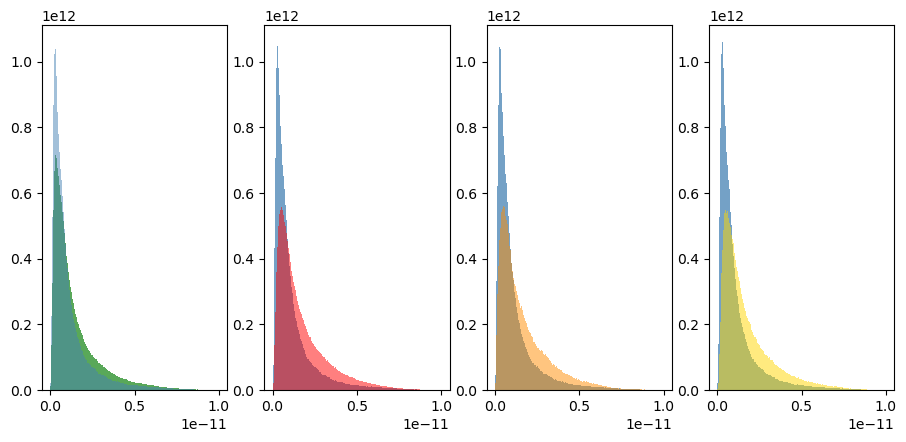

In [105]:
# define bins
h_bins = np.histogram_bin_edges(sd_dat['400kmDensity'],bins='fd',range=(0,1E-11))

density=True

fig, ax = plt.subplots(1,4, figsize=(11,5),gridspec_kw={'bottom':0.15})

ax[0].hist(sd_dat['400kmDensity'],bins=h_bins, alpha = 0.75, label='All', density=density, color='forestgreen')
ax[0].hist(sd_dat.loc[qt_t,'400kmDensity'],bins=h_bins, alpha = 0.5, label='Quiet', density=density, color='steelblue')

ax[1].hist(sd_dat.loc[qt_t,'400kmDensity'],bins=h_bins, alpha = 0.75, label='Quiet', density=density, color='steelblue')
ax[1].hist(sd_dat.loc[st_t,'400kmDensity'],bins=h_bins, alpha = 0.5, label='Storm', density=density, color= 'red')

ax[2].hist(sd_dat.loc[qt_t,'400kmDensity'],bins=h_bins, alpha = 0.75, label='Quiet', density=density, color='steelblue')
ax[2].hist(sd_dat.loc[mn_p,'400kmDensity'],bins=h_bins, alpha = 0.5, label='Main Phase', density=density, color='darkorange')

ax[3].hist(sd_dat.loc[qt_t,'400kmDensity'],bins=h_bins, alpha = 0.75, label='Quiet', density=density, color='steelblue')
ax[3].hist(sd_dat.loc[rc_p,'400kmDensity'],bins=h_bins, alpha = 0.5, label='Recovery Phase', density=density, color='gold')

fig.draw



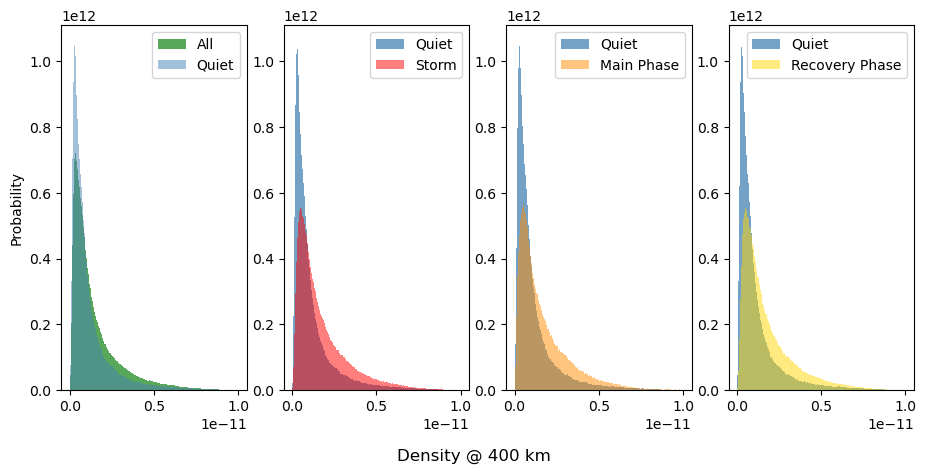

In [106]:
#pretty the figure
for axn in ax:
    axn.legend(loc='upper right')
    axn.ticklabel_format(axis='y',style='sci', scilimits=(0,0))


ax[0].set_ylabel('Probability')
fig.supxlabel('Density @ 400 km', y=0.002)
fig
#plt.savefig(os.path.join(save_dir,'Queit_Storm_Pow.png'),facecolor='white', edgecolor='none')

# CDFs

The histograms illustrate that the distrubtions of density at 400 km are signifanctly different. The storm distributions having larger and longer tails at high density with fewer observations at low desnity. 

This can be further illustrated with the CDFs.

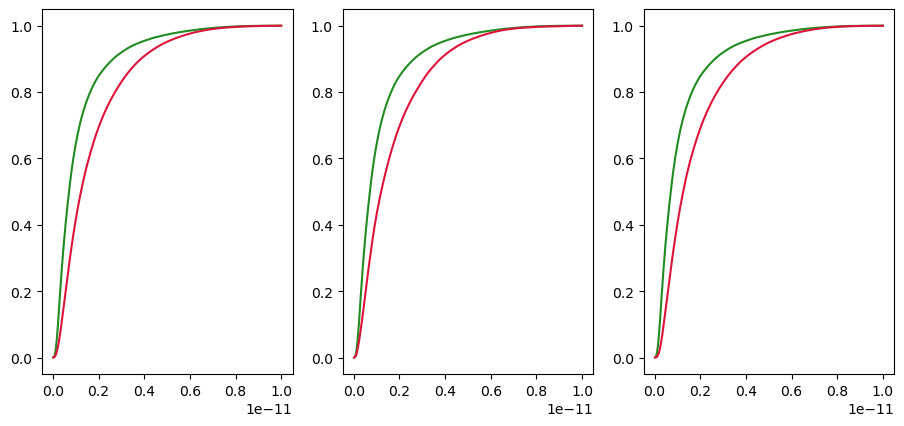

In [118]:
dist_1 = [qt_t, qt_t, qt_t]
dist_2 = [st_t, mn_p, rc_p]

fig2, ax2 = plt.subplots(1,3, figsize=(11,5),gridspec_kw={'bottom':0.15})

# histogram quiet time data
qt_count, qt_bins = np.histogram(sd_dat.loc[qt_t,'400kmDensity'], bins=h_bins)
qt_pdf = qt_count / sum(qt_count) # calculate pdf
qt_cdf = np.cumsum(qt_pdf) # calculate cdf


#plt.plot(qt_bins[1:], qt_cdf, color="forestgreen", label="Quiet")

for axn, dist, in zip(ax2, dist_2):
    lp_count, lp_bins = np.histogram(sd_dat.loc[dist,'400kmDensity'], bins=h_bins)
    lp_pdf = lp_count / sum(lp_count) # calculate pdf
    lp_cdf = np.cumsum(lp_pdf) # calculate cdf

    axn.plot(qt_bins[1:], qt_cdf, color="forestgreen", label="Quiet")
    axn.plot(lp_bins[1:], lp_cdf, color="crimson")

#plt.plot(bins_count_s[1:], cdf_s, color="crimson", label='Storm')

# plotting max difference
#pos = np.argmax(cdf-cdf_s)
#x = [bins_count_s[pos+1],bins_count_s[pos+1]]
#y = [np.abs(cdf_s[pos]-cdf[pos])+np.min([cdf[pos],cdf_s[pos]]),np.min([cdf[pos],cdf_s[pos]])]
#plt.plot(x,y, color="orange", label='Max Difference')

#plt.legend()
#plt.xlabel('Log ULF Power')
#plt.ylabel('Probability')

#plt.savefig(os.path.join(save_dir,'Queit_Storm_CDF.png'),facecolor='white', edgecolor='none')